In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, Dropout, Flatten, BatchNormalization, MaxPool1D, Activation
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
import os

In [2]:
from src.models.conv_model import build_model as build_conv_model
from src.data_loader.RNASeqLoader import RNASeqDataGenerator 
from src.models.conv_model import correlation_coefficient_loss, pearson_r

test_generator = RNASeqDataGenerator("data/processed/cDNA-CBE/validation_data.hdf5", 1024)

Using TensorFlow backend.


In [3]:
import numpy
from src.models.conv_model import build_model as build_conv_model
import tensorflow as tf
from src.evaluator.evaluator import Evaluator
from src.models.conv_model import correlation_coefficient_loss, pearson_r

dependencies = {
    'correlation_coefficient_loss': correlation_coefficient_loss,
    'pearson_r': pearson_r
}
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"

from tensorflow import keras
model = keras.models.load_model('models/cDNA-CBE/opmodel-04-0.0026.h5', custom_objects= dependencies)
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 101, 64)           4160      
_________________________________________________________________
batch_normalization (BatchNo (None, 101, 64)           256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 101, 32)           32800     
_________________________________________________________________
batch_normalizati

In [4]:
preds = model.predict(test_generator, workers = 5, use_multiprocessing=True)

In [5]:
from tqdm import tqdm
gt = list()
for x in tqdm(test_generator):
    gt.append(x[1])

100%|██████████| 416/416 [07:22<00:00,  1.06s/it]


In [6]:
import numpy as np
edit_ground_truth = np.concatenate(gt)
edit_preds = np.array(preds)

In [7]:
print(edit_preds.shape)
edit_preds = preds

(851968, 1)


In [8]:
edit_ground_truth = edit_ground_truth.reshape(edit_ground_truth.shape[0], 1)
edit_preds = edit_preds.reshape(edit_preds.shape[0], 1)

In [9]:

res = np.hstack((edit_ground_truth, edit_preds))
import pandas as pd
df = pd.DataFrame(data=res)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import tensorflow as tf
bce = tf.keras.losses.BinaryCrossentropy()
out = (bce(edit_ground_truth, edit_preds))
#out = bce([1.11,0.0001,0.01001,0.0001,0.01001,0.0001,0.0001, 0.3], [0.1,0.0001,0.0001,0.0001,0.0001,0.00101,0.0001, 0.3])
loss = out.eval(session=tf.compat.v1.Session()) 

In [10]:
from scipy import stats

pr = stats.pearsonr(edit_ground_truth.squeeze(), edit_preds.squeeze())[0]

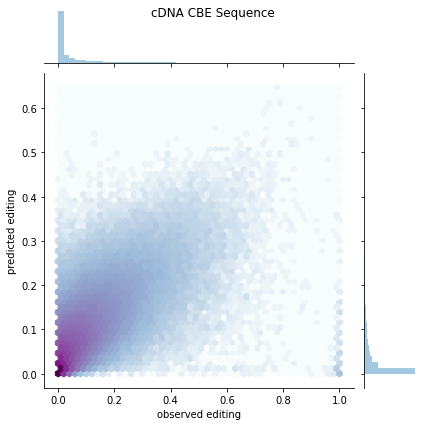

Binary cross-entropy Loss: 0.132233
Pearson r: 0.7662


In [12]:
import seaborn as sns
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
import scipy.stats as stats
import matplotlib.cm as cm
import matplotlib.pyplot as plt
df.columns = ['observed editing', 'predicted editing']
p = sns.jointplot(data=df, x="observed editing", y="predicted editing", kind="hex", bins='log',  cmap='BuPu')
#p.annotate(stats.pearsonr)
p.fig.suptitle("cDNA CBE Sequence")
plt.show()
print("Binary cross-entropy Loss: {:.6f}".format(loss))
print("Pearson r: {:.4f}".format(pr))